# Generate test comparison data

Notebook with which the comparison data for the tests is generated, in case the old results are no longer valid.

In [1]:
import pandas as pd
import sys
sys.path.append('../../anduryl')
import anduryl
import numpy as np
from hkvpy import plotting
import seaborn as sns

plotting.set_rcparams()

### Validation table

In [2]:
# Case name - file
files = {
    'Arkansas': 'Arkansas.mat',
    'Arsenic': 'arsenic d-r.mat',
    'ATCEP': 'ATCEP Error.mat',
    'Biol_Agent': 'Biol agents.mat',
    'CDC_ROI': 'CDC ROI Final.mat',
    'CoveringKids': 'CoveringKids.mat',
    'create-vicki': 'create.mat',
    'CWD': 'cwd.mat',
    'Daniela': 'Daniela.mat',
    'DCPN_Fistula': 'dcpn_fistula.mat',
    'eBPP': 'ebbp.mat',
    'Eff_Erup': 'EffusiveErupt.mat',
    'Erie_Carp': 'Erie Carps.mat',
    'FCEP': 'FCEP Error.mat',
    'Florida': 'Florida.mat',
    'Gerstenberger': 'Gerstenberger.mat',
    'GL_NIS': 'gl-nis.mat',
    'Goodheart': 'Goodheart.mat',
    'Hemopilia': 'Hemophilia.mat',
    'IceSheets': 'IceSheet2012.mat',
    'Illinois': 'Illinois.mat',
    'Liander': 'liander.mat',
    'Nebraska': 'Nebraska.mat',
    'Obesity': 'obesity_ms.mat',
    'PHAC_T4': 'PHAC 2009 final.mat',
    'San_Diego': 'San Diego.mat',
    'Sheep': 'Sheep Scab.mat',
    'SPEED': 'speed.mat',
    'TDC': 'tdc.mat',
    'Tobacco': 'tobacco.mat',
    'Topaz': 'Topaz.mat',
    'UMD_NREMOVAL': 'umd_nremoval.mat',
    'Washington': 'Washington.mat'
}


In [3]:
# Load Excalibur table as format
validation_table = pd.read_csv('../test/data/Excalibur.csv', sep=';', header=[0, 1], index_col=0)
validation_table.head()

Characteristics Characteristics      Equal weight              \
Study                      #Exp #Cal           Sa   Inf  Comb   
Arkansas                      4   10         0.39  0.20  0.08   
Arsenic                       9   10         0.06  1.10  0.07   
ATCEP                         5   10         0.12  0.25  0.03   
Biol_Agent                   12   12         0.41  0.24  0.10   
CDC_ROI                      20   10         0.23  1.23  0.29   

Characteristics PW Non-optimized             PW Global             PW Item  \
Study                         Sa   Inf  Comb        Sa   Inf  Comb      Sa   
Arkansas                    0.50  0.34  0.17      0.50  0.34  0.17    0.50   
Arsenic                     0.04  1.68  0.06      0.04  2.74  0.10    0.04   
ATCEP                       0.68  0.23  0.16      0.68  0.23  0.16    0.24   
Biol_Agent                  0.41  0.43  0.18      0.68  0.61  0.41    0.68   
CDC_ROI                     0.39  1.35  0.52      0.72  2.31  1.66    0.72   

Characteristics             Best Expert              
Study             Inf  Comb          Sa   Inf  Comb  
Arkansas         0.52  0.26        0.07  0.41  0.03  
Arsenic          2.74  0.10        0.04  2.74  0.10  
ATCEP            0.38  0.09        0.10  0.50  0.05  
Biol_Agent       0.66  0.45        0.31  1.00  0.31  
CDC_ROI          2.31  1.66        0.72  2.31  1.66

In [4]:
anduryl_piecewiselinear = validation_table.copy()

for key, file in files.items():
    
    anduryl.core.experts.USE_METALOG = False

    project = anduryl.Project()
    file = file.replace('.mat', '')
    project.io.load_excalibur(f'../cases/{file}.dtt', f'../cases/{file}.rls')
    if project.assessments.quantiles != [0.05, 0.5, 0.95]:
        anduryl_piecewiselinear.drop(key, axis=0, inplace=True)
        continue
   
    project.calculate_decision_maker(weight_type='item', overshoot=0.1, exp_id='DM1', exp_name='Item opt.')
    itemopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'PW Item'] = itemopt
    print(sum(project.experts.calibration[:-1] > 0.05))

    project.calculate_decision_maker(weight_type='global', overshoot=0.1, exp_id='DM2', exp_name='Global opt.')
    globopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'PW Global'] = globopt

    project.calculate_decision_maker(weight_type='global', alpha=0.0, overshoot=0.1, exp_id='DM3', exp_name='Global Non-opt.')
    globnonopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'PW Non-optimized'] = globnonopt

    project.calculate_decision_maker(weight_type='equal', overshoot=0.1, exp_id='DM4', exp_name='Equal')
    equal = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'Equal weight'] = equal

    imax = np.argmax([project.experts.comb_score[i] for i in project.experts.actual_experts])
    ibest = project.experts.actual_experts[imax]
    best_exp = np.round([project.experts.calibration[ibest], project.experts.info_real[ibest], project.experts.info_real[ibest] * project.experts.calibration[ibest]], 2)
    anduryl_piecewiselinear.loc[key, 'Best Expert'] = best_exp
    
#     print(key, globnonopt, 'global non opt')
#     print(key, equal, 'Equal weight')
#     print(key, best_exp, 'Best Expert')
#     print()
    
#     break

0
1
2
0
5
2
7
3
9
2
2
2
3
0
0
1
1
3
2
2


In [8]:
anduryl_metalog = validation_table.copy()

import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()

for key, file in files.items():
    
    anduryl.core.experts.USE_METALOG = True

    project = anduryl.Project()
    file = file.replace('.mat', '')
    project.io.load_excalibur(f'../cases/{file}.dtt', f'../cases/{file}.rls')
    if project.assessments.quantiles != [0.05, 0.5, 0.95]:
        anduryl_metalog.drop(key, axis=0, inplace=True)
        continue
        
    project.calculate_decision_maker(weight_type='item', overshoot=0.1, exp_id='DM1', exp_name='Item opt.')
    print(sum(project.experts.calibration[:-1] > 0.05))
    
    itemopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'PW Item'] = itemopt

    project.calculate_decision_maker(weight_type='global', overshoot=0.1, exp_id='DM2', exp_name='Global opt.')
    globopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'PW Global'] = globopt

    project.calculate_decision_maker(weight_type='global', alpha=0.0, overshoot=0.1, exp_id='DM3', exp_name='Global Non-opt.')
    globnonopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'PW Non-optimized'] = globnonopt

    project.calculate_decision_maker(weight_type='equal', overshoot=0.1, exp_id='DM4', exp_name='Equal')
    equal = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'Equal weight'] = equal

    imax = np.argmax([project.experts.comb_score[i] for i in project.experts.actual_experts])
    ibest = project.experts.actual_experts[imax]
    best_exp = np.round([project.experts.calibration[ibest], project.experts.info_real[ibest], project.experts.info_real[ibest] * project.experts.calibration[ibest]], 2)
    anduryl_metalog.loc[key, 'Best Expert'] = best_exp
    
#     print(key, globnonopt, 'global non opt')
#     print(key, equal, 'Equal weight')
#     print(key, best_exp, 'Best Expert')
#     print()

    print(key)
    
#     break
    
pr.disable()

pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
with open("D:/Documents/profile.txt", "w") as f:
    f.write(s.getvalue())

1
Arsenic
1
ATCEP
7
Biol_Agent
1
create-vicki
9
CWD
3
Daniela
9
eBPP
7
Eff_Erup


d:\Documents\GitHub\anduryl\notebooks\../../anduryl\anduryl\core\experts.py:789: RuntimeWarning: invalid value encountered in true_divide
  "Answered seed items": nseed,


9


d:\Documents\GitHub\anduryl\notebooks\../../anduryl\anduryl\core\calculate.py:102: RuntimeWarning: invalid value encountered in true_divide
  weights[:, :, iq] /= numerator


Erie_Carp
2
FCEP
6
GL_NIS
5
Goodheart
6
IceSheets
1
Liander
3
PHAC_T4
6
Sheep
2
SPEED
9
TDC
5
Topaz
2
UMD_NREMOVAL


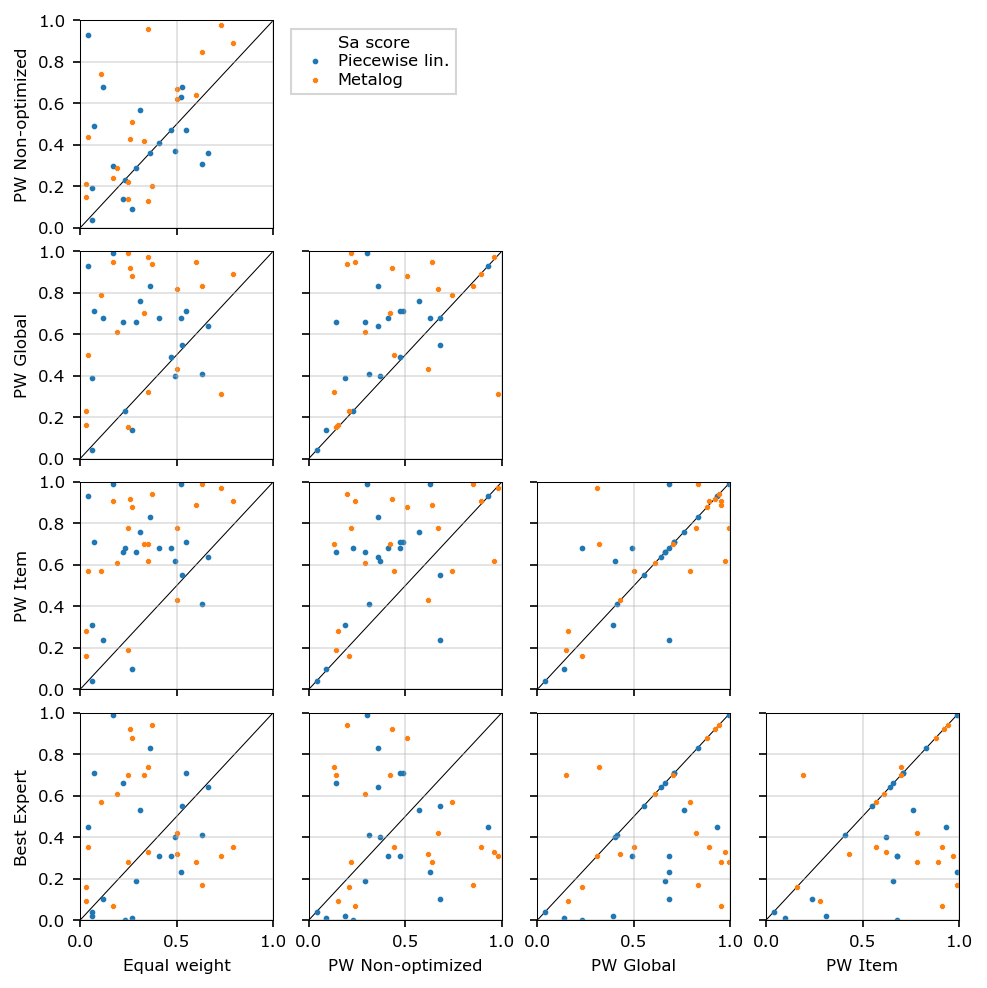

In [9]:
cols = ['Equal weight', 'PW Non-optimized', 'PW Global', 'PW Item', 'Best Expert']

import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 5, figsize=(8, 8), sharex=True, sharey=True)

# for comb in [
#     ['Equal weight', 'PW Non-optimized'],
#     ['PW Non-optimized',],
#     ['Equal weight'],
# ]

# import seaborn as sns

score = 'Sa'

maxlim = {
    'Sa': 1,
    'Inf': 3,
    'Comb': 1.5
}[score]

data1 = anduryl_piecewiselinear.loc[:, (slice(None), score)].copy()
data1.columns = data1.columns.get_level_values(0)

data2 = anduryl_metalog.loc[:, (slice(None), score)].copy()
data2.columns = data2.columns.get_level_values(0)

# maxlim = max(data1.max().max(), data2.max().max()) * 1.05

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        ax.grid()
        if i <= j:
            fig.delaxes(ax)
            continue
#             ax.set_xlim(0, 1.5)
        else:
            ax.axis((0, maxlim, 0, maxlim))
            ax.scatter(data1[cols[j]], data1[cols[i]], s=3, color='C0', label='Piecewise lin.')
            ax.scatter(data2[cols[j]], data2[cols[i]], s=3, color='C1', label='Metalog', marker='x')
            ax.plot([0, maxlim], [0, maxlim], color='k', lw=0.5, ls='-', zorder=-10)
            
            if i == 4:
                ax.set_xlabel(cols[j])
            if j == 0:
                ax.set_ylabel(cols[i])

           
plt.tight_layout(pad=0.5)
axs[1, 0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title=score+' score')
        

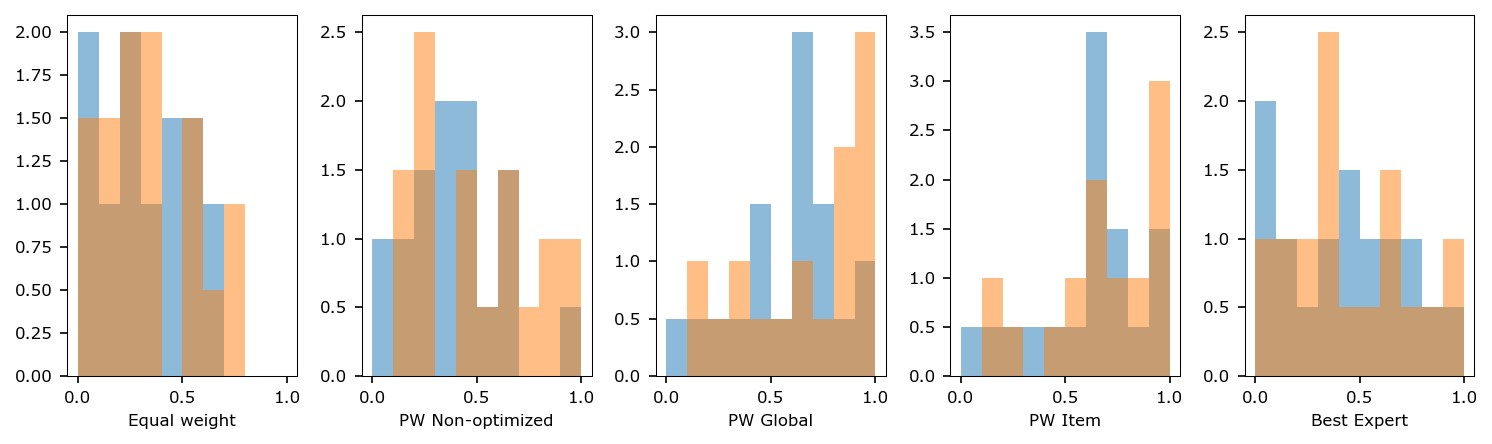

In [39]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

xgrid = np.linspace(0, maxlim, 100)

fig, axs = plt.subplots(figsize=(10, 3), ncols=len(cols))
for ax, col in zip(axs, cols):
    
#     y = kde_scipy(data1[col], xgrid, bandwidth=0.05)
#     ax.plot(xgrid, y)
    ax.hist(data1[col], color='C0', alpha=0.5, density=True, range=(0, 1))
    
#     y = kde_scipy(data2[col], xgrid, bandwidth=0.05)
#     ax.plot(xgrid, y)
    ax.hist(data2[col], color='C1', alpha=0.5, density=True, range=(0, 1))
    ax.set(xlabel=col)

fig.tight_layout()
    
#     sns.kdeplot(data=data2[col], ax=ax)
#     sns.histplot(data=data1[col], ax=ax)
#     sns.histplot(data=data2[col], ax=ax)

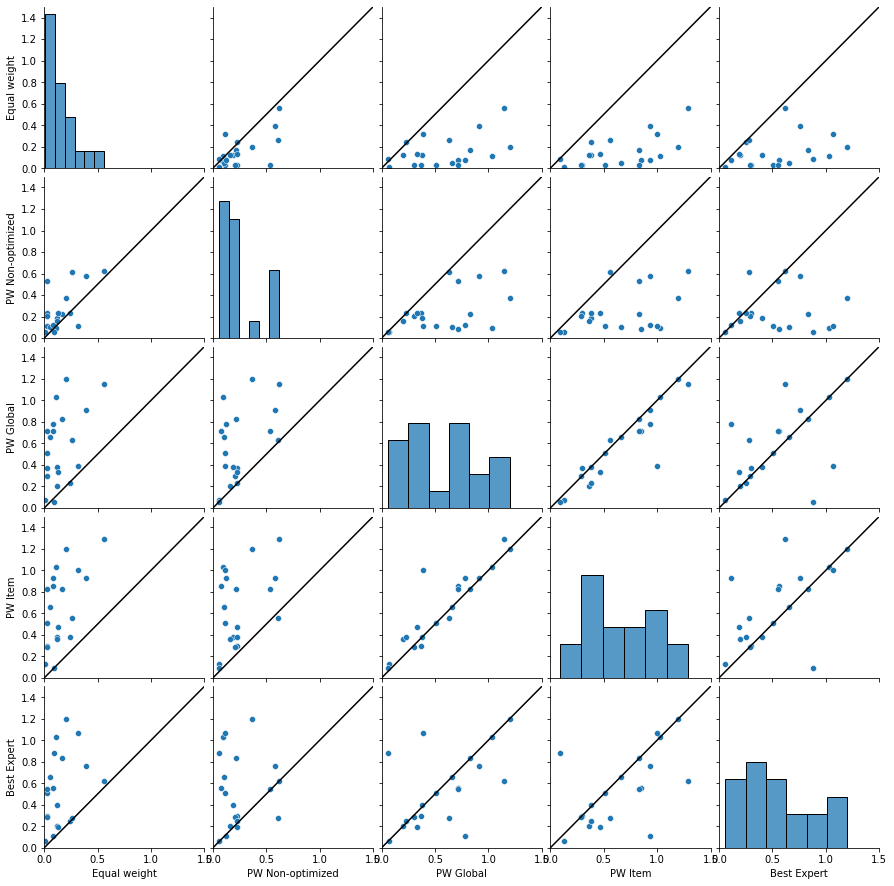

In [29]:
# ['Equal weight', 'PW Non-optimized', 'PW Global', 'PW Item', 'Best Expert']

# for comb in [
#     ['Equal weight', 'PW Non-optimized'],
#     ['PW Non-optimized',],
#     ['Equal weight'],
# ]

import seaborn as sns

data = anduryl_metalog.loc[:, (slice(None), 'Comb')].copy()
data.columns = data.columns.get_level_values(0)

grid = sns.pairplot(data)

for i in range(5):
    for j in range(5):
        ax = grid.axes[i, j]
        if i == j:
            ax.set_xlim(0, 1.5)
        else:
            ax.axis((0, 1.5, 0, 1.5))
            ax.plot([0, 2], [0, 2], color='k')

array([[<AxesSubplot:ylabel='Equal weight'>,
        <AxesSubplot:xlabel='PW Non-optimized', ylabel='Equal weight'>,
        <AxesSubplot:xlabel='PW Global', ylabel='Equal weight'>,
        <AxesSubplot:xlabel='PW Item', ylabel='Equal weight'>,
        <AxesSubplot:xlabel='Best Expert', ylabel='Equal weight'>],
       [<AxesSubplot:xlabel='Equal weight', ylabel='PW Non-optimized'>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='PW Global', ylabel='PW Non-optimized'>,
        <AxesSubplot:xlabel='PW Item', ylabel='PW Non-optimized'>,
        <AxesSubplot:xlabel='Best Expert', ylabel='PW Non-optimized'>],
       [<AxesSubplot:xlabel='Equal weight', ylabel='PW Global'>,
        <AxesSubplot:xlabel='PW Non-optimized', ylabel='PW Global'>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='PW Item', ylabel='PW Global'>,
        <AxesSubplot:xlabel='Best Expert', ylabel='PW Global'>],
       [<AxesSubplot:xlabel='Equal weight', ylabel='PW Item'>,
        <AxesSubplot:xlabel='PW Non-o

In [10]:
anduryl_metalog

Characteristics Characteristics      Equal weight              \
Study                      #Exp #Cal           Sa   Inf  Comb   
Arsenic                       9   10         0.03  1.10  0.03   
ATCEP                         5   10         0.11  0.25  0.03   
Biol_Agent                   12   12         0.50  0.24  0.12   
create-vicki                  7   10         0.03  0.21  0.01   
CWD                          14   10         0.60  0.93  0.56   
Daniela                       4    7         0.73  0.17  0.12   
eBPP                         14   15         0.25  0.32  0.08   
Eff_Erup                     14    8         0.50  0.80  0.39   
Erie_Carp                    11   15         0.37  0.29  0.11   
FCEP                          5    8         0.27  0.10  0.03   
GL_NIS                        9   13         0.79  0.31  0.24   
Goodheart                     6   10         0.19  0.28  0.05   
IceSheets                    10   11         0.33  0.52  0.17   
Liander                      11   10         0.17  0.48  0.08   
PHAC_T4                      10   13         0.63  0.20  0.13   
Sheep                        14   15         0.26  0.78  0.20   
SPEED                        14   16         0.35  0.75  0.26   
TDC                          18   17         0.25  0.36  0.09   
Topaz                        21   16         0.35  0.92  0.32   
UMD_NREMOVAL                  9   11         0.04  0.80  0.03   

Characteristics PW Non-optimized             PW Global             PW Item  \
Study                         Sa   Inf  Comb        Sa   Inf  Comb      Sa   
Arsenic                     0.21  1.10  0.23      0.23  1.63  0.37    0.16   
ATCEP                       0.74  0.29  0.21      0.79  0.38  0.30    0.57   
Biol_Agent                  0.62  0.31  0.19      0.43  0.88  0.38    0.43   
create-vicki                0.15  0.40  0.06      0.16  0.43  0.07    0.28   
CWD                         0.64  0.96  0.62      0.95  1.20  1.15    0.89   
Daniela                     0.98  0.16  0.16      0.31  0.63  0.20    0.97   
eBPP                        0.22  0.35  0.08      0.99  0.72  0.72    0.78   
Eff_Erup                    0.67  0.86  0.58      0.82  1.11  0.91    0.78   
Erie_Carp                   0.20  0.44  0.09      0.94  1.09  1.03    0.94   
FCEP                        0.51  0.22  0.11      0.88  0.57  0.51    0.88   
GL_NIS                      0.89  0.26  0.23      0.89  0.26  0.23    0.91   
Goodheart                   0.29  0.35  0.10      0.61  1.10  0.66    0.61   
IceSheets                   0.42  0.53  0.22      0.70  1.18  0.83    0.70   
Liander                     0.24  0.51  0.12      0.95  0.82  0.78    0.91   
PHAC_T4                     0.85  0.27  0.23      0.83  0.40  0.33    0.99   
Sheep                       0.43  0.85  0.37      0.92  1.31  1.20    0.92   
SPEED                       0.96  0.64  0.61      0.97  0.65  0.63    0.62   
TDC                         0.14  0.40  0.06      0.15  0.40  0.06    0.19   
Topaz                       0.13  0.86  0.11      0.32  1.22  0.39    0.70   
UMD_NREMOVAL                0.44  1.21  0.53      0.50  1.44  0.72    0.57   

Characteristics             Best Expert              
Study             Inf  Comb          Sa   Inf  Comb  
Arsenic          1.90  0.30        0.16  1.90  0.30  
ATCEP            0.50  0.29        0.57  0.50  0.29  
Biol_Agent       0.88  0.38        0.32  1.24  0.40  
create-vicki     0.48  0.13        0.09  0.65  0.06  
CWD              1.45  1.29        0.28  2.19  0.62  
Daniela          0.37  0.36        0.31  0.63  0.20  
eBPP             1.08  0.85        0.28  1.99  0.56  
Eff_Erup         1.19  0.93        0.42  1.80  0.76  
Erie_Carp        1.09  1.03        0.94  1.09  1.03  
FCEP             0.57  0.51        0.88  0.57  0.51  
GL_NIS           0.42  0.38        0.35  0.70  0.25  
Goodheart        1.10  0.66        0.61  1.10  0.66  
IceSheets        1.18  0.83        0.70  1.18  0.83  
Liander          1.03  0.93        0.07  1